In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split
from smote import smote_binary
from skorch import NeuralNetClassifier
from performance_report import performance_report
from sklearn import metrics

In [38]:
# setup 
device = torch.device('cpu')
bucket = 'm-team1'
role = get_execution_role()    
file = 'PD_remove_std_all_datasets.csv'
data_loc = 's3://{}/{}'.format(bucket, file)

In [39]:
# reading CSV and separating data into train and test sets 

df = pd.read_csv(data_loc).iloc[: , 1:]

X = df.iloc[:,1:]
y = df.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

augment = True

if augment:
    df_train = pd.concat([y_train, X_train], axis=1)
    df_train = smote_binary(df_train)
    X_train = df_train.iloc[:,1:]
    y_train = df_train.iloc[:,0]

    X = torch.tensor(pd.concat([X_train, X_test]).values.astype(np.float32))
    y = torch.tensor(pd.concat([y_train, y_test]).values.astype(np.long))
    
else:
    X = torch.tensor(X.values.astype(np.float32))
    y = torch.tensor(y.values.astype(np.long))   
    
print(X.size())
print(y.size())
    
X_train = torch.tensor(X_train.values.astype(np.float32))
X_test = torch.tensor(X_test.values.astype(np.float32))
y_train = torch.tensor(y_train.values.astype(np.long))
y_test = torch.tensor(y_test.values.astype(np.long))

torch.Size([11627, 14])
torch.Size([11627])


In [40]:
class Model(nn.Module):
    def __init__(self, input_dim=14):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [41]:
net = NeuralNetClassifier(
    Model,
    max_epochs=15,
    lr=0.001,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
)

net.fit(X_train, y_train)

y_pred = net.predict(X_test)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5567       0.9451        0.4168  0.1837
      2        0.3820       0.9524        0.3674  0.1801
      3        0.3657       0.9558        0.3610  0.1807
      4        0.3616       0.9578        0.3575  0.1805
      5        0.3592       0.9592        0.3556  0.1803
      6        0.3578       0.9602        0.3542  0.1805
      7        0.3556       0.9636        0.3525  0.1917
      8        0.3542       0.9626        0.3529  0.1806
      9        0.3532       0.9641        0.3517  0.1930
     10        0.3525       0.9641        0.3509  0.1803
     11        0.3517       0.9655        0.3502  0.1803
     12        0.3513       0.9660        0.3491  0.2142
     13        0.3507       0.9631        0.3508  0.1824
     14        0.3502       0.9650        0.3486  0.1812
     15        0.3501       0.9660        0.3483  0.1804


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5092       0.9412        0.4015  0.1661
      2        0.3808       0.9422        0.3744  0.1675
      3        0.3704       0.9479        0.3688  0.1684
      4        0.3674       0.9494        0.3663  0.1721
      5        0.3656       0.9494        0.3647  0.1693
      6        0.3647       0.9510        0.3637  0.1667
      7        0.3639       0.9505        0.3633  0.1672
      8        0.3628       0.9520        0.3621  0.1669
      9        0.3617       0.9520        0.3610  0.1679
     10        0.3594       0.9551        0.3589  0.1675
     11        0.3576       0.9541        0.3600  0.1663
     12        0.3563       0.9520        0.3591  0.1669
     13        0.3552       0.9587        0.3561  0.1669
     14        0.3554       0.9577        0.3562  0.1682
     15        0.3536       0.9598        0.3549  0.1665
  epoch    train_loss    valid_

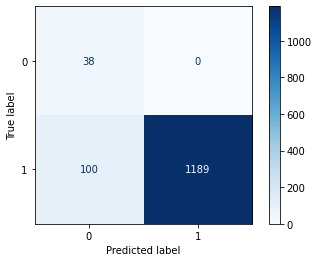

In [42]:
performance_report(net, X, y, X_test, y_test, y_pred, "binary_remove_augment")

In [43]:
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.28      0.43       138
           1       0.92      1.00      0.96      1189

    accuracy                           0.92      1327
   macro avg       0.96      0.64      0.70      1327
weighted avg       0.93      0.92      0.90      1327

